Traditionally, time series forecasting has been dominated by linear methods because they are well understood and effective on many simpler forecasting problems. However, deep learning neural networks are able to automatically learn arbitrary complex mappings from inputs to outputs and support multiple inputs and outputs. We used a deeplearning network with LeakyReLU activation in this model.

## **Import important Libraries**

We will first import all the requared libraries in one cell

In [1]:
#imporing required libraries
import pandas as pd
import ubiquant
import gc, random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (15, 5)

### **Load Data and inspect Data**

Since our data is 18Gb, we converted it to a parcuet file to reduce the memory. We will be using the parcuet file in this notebook. Let first load and inspect the train dataset.

In [2]:
#loading the train dataset and printing the first 5 rows
train = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')
train.head(5)

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [3]:
#geting a general overview of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


We will look for the number of unique values for both the time_id and investment_id.

In [4]:
#looking for unique values in the 
n = len(pd.unique(train['time_id']))
print('No of unique time_id values: ', n)
#for the dataset there are 1220 unique timestamps.

m = len(pd.unique(train['investment_id']))
print('No of unique ivestment_id values: ', m)

No of unique time_id values:  1211
No of unique ivestment_id values:  3579


We can also inspect if the data has missing values

In [5]:
#looking for the number of null values for each column in our dataset
train.isnull().sum()

row_id           0
time_id          0
investment_id    0
target           0
f_0              0
                ..
f_295            0
f_296            0
f_297            0
f_298            0
f_299            0
Length: 304, dtype: int64

In [6]:
#The total number of null values for the whole training dataset
train.isnull().sum().sum()

0

The training dataset has 3141410 rows and 304 column entries. The colums of our data include (row_id, time_id, investimaent_id, target, and f_0 to f_299 features). 

The time_id and investment id have 1211 and 3579 unique values respectively.

No of unique time_id values:  1211,
No of unique ivestment_id values:  3579

Since our data has no missing values, we can prossed to looking at the example_sample_submission file.

In [7]:
#loading the example_sample_sebmission file
df = pd.read_parquet('../input/ubiquant-parquet/example_sample_submission.parquet')
df.head()

,row_id,time_id,target
0,1220_1,1220,0
1,1220_2,1220,0
2,1221_0,1221,0
3,1221_1,1221,0
4,1221_2,1221,0


### **Plots of Targets Time Series**

We plotted the target for a random of 10 stocks to see how it looks. The stock is represented by the investment_id.

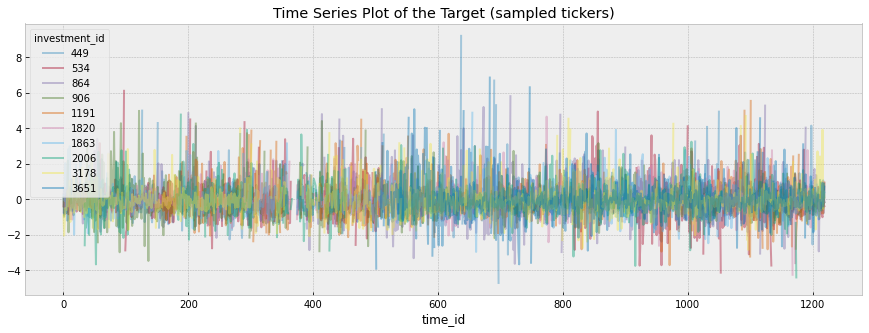

In [8]:
sample_tickers = random.sample(list(train.investment_id.unique()), 10)

(train
 .query('investment_id in @sample_tickers')
 .set_index(['time_id', 'investment_id'])['target']
 .unstack()
 .plot(alpha=0.4,
       title='Time Series Plot of the Target (sampled tickers)'));


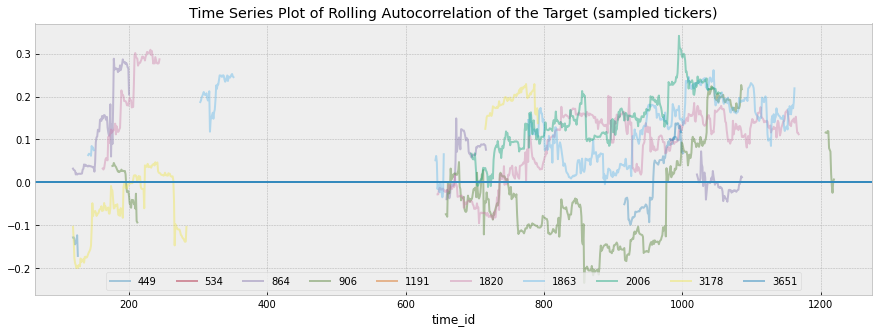

In [9]:
(train
 .query('investment_id in @sample_tickers')
 .set_index(['time_id', 'investment_id'])['target']
 .unstack()
 .rolling(120)
 .apply(lambda x: x.autocorr(), raw=False)
 .plot(alpha=0.4,
       title='Time Series Plot of Rolling Autocorrelation of the Target (sampled tickers)')
 .legend(loc='lower center',
         ncol=len(sample_tickers)));
plt.axhline(0);

In [10]:
targets_wide = (
    train
    .filter([
        'time_id',
        'investment_id',
        'target'])
    .set_index(['time_id', 'investment_id'])
    .unstack()
    .droplevel(0, axis=1))

targets_wide.head(5)

investment_id,0,1,2,3,4,6,7,8,9,10,...,3763,3764,3765,3766,3767,3768,3769,3770,3772,3773
time_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,-0.300875,-0.231040,NaN,NaN,0.568807,-1.064780,-0.531940,1.505904,-0.260731,...,NaN,NaN,0.302557,0.003156,NaN,-0.392297,-0.877746,-0.284696,0.202003,NaN
1,NaN,-0.917045,-0.472108,NaN,NaN,-0.147971,-0.372692,-0.105693,0.622500,-0.400038,...,NaN,NaN,-0.560079,0.250396,1.318857,-0.227782,-0.684049,-0.894825,-0.286612,NaN
2,NaN,-0.480234,-0.661659,NaN,NaN,0.243674,0.318899,-0.260137,-0.610705,-1.030857,...,NaN,NaN,-0.305467,2.031675,-0.040981,-0.018971,-0.250995,-0.323800,0.300915,NaN
3,NaN,-0.323562,-0.055215,NaN,NaN,1.816745,-0.711446,-0.640987,5.271096,-0.636719,...,NaN,NaN,-0.730791,0.857357,0.386379,-0.708491,-0.165561,0.836601,0.076417,NaN
4,NaN,2.494479,0.341267,NaN,NaN,0.470476,-1.581650,-0.592970,NaN,-0.435524,...,NaN,NaN,-0.656495,1.897659,-1.476258,-0.210125,-0.206145,0.126859,-0.387297,NaN


### **Data Preprocesing**

We used all tha features in the data for model traing. We had earler include the investment_id in our model train. Since "f_#" columns are similar to standard normal distribution, "investment_id" column was to be converted (standardized) with StandardScaler in sklearn for efficient training. Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data.

We maked use of scaler so that we can apply the same criteria to test dataset later.

However, our model peformed better without including the investment id, and therefor, we did not include the investment_id when finetuning the model.

We then defined a function that was to be used to extract only the features for model traing and prediction.

In [11]:
#desplaying the column names
columns = train.columns
columns

Index(['row_id', 'time_id', 'investment_id', 'target', 'f_0', 'f_1', 'f_2',
       'f_3', 'f_4', 'f_5',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=304)

In [12]:
#desplying a list of the all features
features = columns[train.columns.str.contains('f_')]
print(features)

Index(['f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9',
       ...
       'f_290', 'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297',
       'f_298', 'f_299'],
      dtype='object', length=300)


In [13]:
#make a scaler with the StandardScaler from sklearn
#scaler = StandardScaler()
#scaler.fit(pd.DataFrame(train['investment_id']))

"""
Compute the mean and std to be used for later scaling.

Parameters:
    Xarray-like of shape (n_samples, n_features)
    Input samples.
Returns:
    X_newndarray array of shape (n_samples, n_features_new)
    Transformed array.
"""

'\nCompute the mean and std to be used for later scaling.\n\nParameters:\n    Xarray-like of shape (n_samples, n_features)\n    Input samples.\nReturns:\n    X_newndarray array of shape (n_samples, n_features_new)\n    Transformed array.\n'


### Make dataset function.
This function takes in the features colunms from the dataframe and save them as a new dataframe. The features only dataframe was to be used for model train and test data predictions.

In [14]:
#defing a function that will take a dataframe and create a new dataframe with features only.
def make_dataset(df):
    #inv_df = df['investment_id']
    f_df = df[features]
    #scaled_investment_id = scaler.transform(pd.DataFrame(inv_df))
    #df['investment_id'] = scaled_investment_id
    #data_x = pd.concat([df['investment_id'], f_df], axis=1)
    #return data_x
    return f_df


Since the notebook memory has a small limit to use the raw data, We changed the data type to "float16". we also divided the dataset into input and output variables. The input data was used to predict the output data. Our input data contain the features information while the output contains the target information. This implys that, the features will be used to predict target.

In [15]:
#input Variable
train = train.astype('float16')
train_x = make_dataset(train)

In [16]:
#the target variable
train_y = pd.DataFrame(train['target'])
train_y

,target
0,-0.300781
1,-0.231079
2,0.568848
3,-1.064453
4,-0.531738
...,...
3141405,0.033600
3141406,-0.223267
3141407,-0.559570
3141408,0.009598


To prevent the notebook memory from exlporing, we delete the raw data to have enough memory for traing the model

In [17]:
#delete raw data
del train

## **Model**

In this work, we used a deep neural network model. The model architecture was borrowed from https://www.kaggle.com/pythonash/end-to-end-simple-and-powerful-dnn-with-leakyrelu/notebook. However, we changed some parameters to improve the model for traing.

### Model Compiling

In [18]:
#define the model function
def Ubiquant_model():
    inputs_ = tf.keras.Input(shape = [train_x.shape[1]])
    x = tf.keras.layers.Dense(64, kernel_initializer = 'he_normal')(inputs_)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(128, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(256, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(512, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(256, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.4)(leaky)
    
    x = tf.keras.layers.Dense(128, kernel_initializer = 'he_normal')(drop)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    
    x = tf.keras.layers.Dense(8, kernel_initializer = 'he_normal')(leaky)
    batch = tf.keras.layers.BatchNormalization()(x)
    leaky = tf.keras.layers.LeakyReLU(0.1)(batch)
    drop = tf.keras.layers.Dropout(0.4)(leaky)
    
    outputs_ = tf.keras.layers.Dense(1)(drop)
    
    model = tf.keras.Model(inputs = inputs_, outputs = outputs_)
    
    rmse = tf.keras.metrics.RootMeanSquaredError()

    learning_sch = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 9700,
    decay_rate = 0.98)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_sch)
    
    #compling the model
    model.compile(loss = 'mse', metrics = rmse, optimizer = adam)
    return model

Ubiquant_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0     

2022-02-28 10:29:43.284504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 10:29:43.392062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 10:29:43.392867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 10:29:43.394143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### **The Model graphics**
The model architecture is printed below for visualiation.

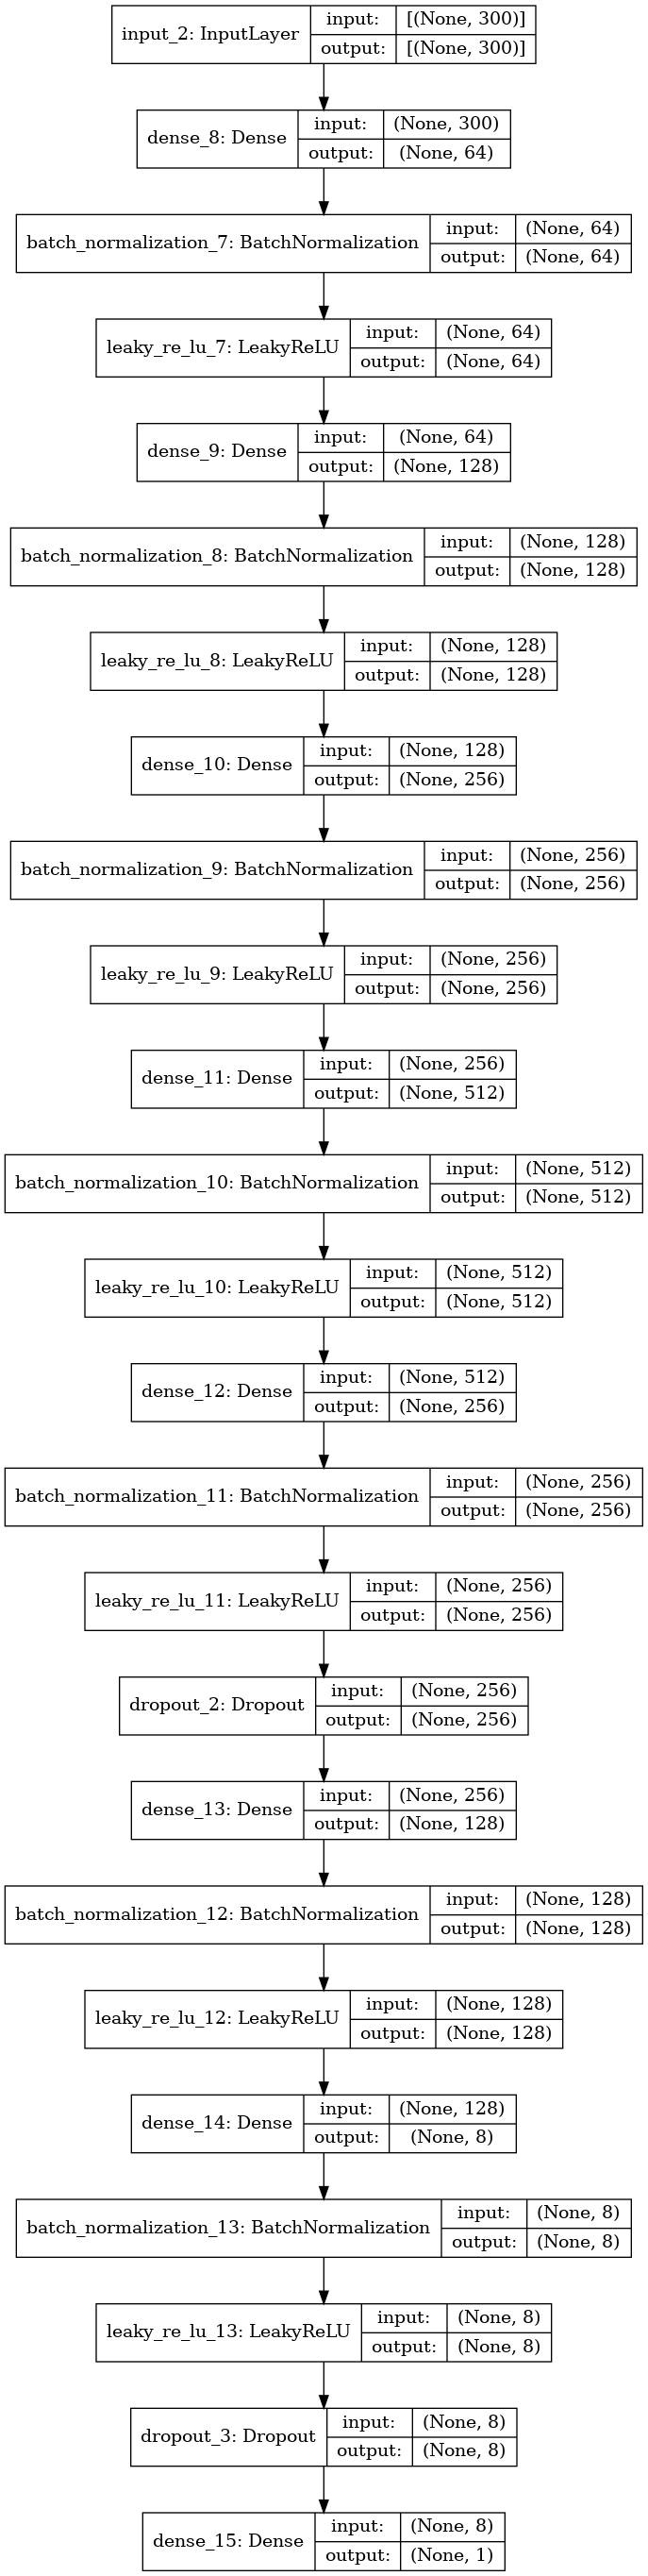

In [19]:
#printing the model graphics
tf.keras.utils.plot_model(Ubiquant_model(),show_shapes=True,expand_nested=True)



### Model Predictions

In [20]:
#generating the Kfolds that will be used as testing and training data
kfold_generator = KFold(n_splits =5, shuffle=True, random_state = 2022)
kfold_generator


KFold(n_splits=5, random_state=2022, shuffle=True)

In [21]:
callbacks = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10)

for train_index, val_index in kfold_generator.split(train_x, train_y):
    # Split training dataset.
    traind_x, traind_y = train_x.iloc[train_index], train_y.iloc[train_index]
    # Split validation dataset.
    val_x, val_y = train_x.iloc[val_index], train_y.iloc[val_index]
    # Make tensor dataset.
    tf_train = tf.data.Dataset.from_tensor_slices((traind_x, traind_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
    tf_val = tf.data.Dataset.from_tensor_slices((val_x, val_y)).shuffle(2022).batch(1024, drop_remainder=True).prefetch(1)
   
    # Load model
    model = Ubiquant_model()
    # Model fitting
    model.fit(tf_train, callbacks = [callbacks,early_stop] , epochs = 5, #### change the epochs into more numbers.
             validation_data = (tf_val), shuffle=True)
    
    # Delete tensor dataset and model for avoiding memory exploring.
    del tf_train
    del tf_val
    del model

2022-02-28 10:29:56.507004: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-02-28 10:29:58.282997: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.
2022-02-28 10:29:59.709146: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376969200 exceeds 10% of free system memory.
2022-02-28 10:30:00.083803: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376969200 exceeds 10% of free system memory.
2022-02-28 10:30:00.526727: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1507876800 exceeds 10% of free system memory.


Epoch 1/5


2022-02-28 10:30:03.845249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2454/2454 [==============================] - 20s 7ms/step - loss: 0.8599 - root_mean_squared_error: 0.9273 - val_loss: 0.8401 - val_root_mean_squared_error: 0.9165
Epoch 2/5
2454/2454 [==============================] - 18s 7ms/step - loss: 0.8311 - root_mean_squared_error: 0.9116 - val_loss: 0.8396 - val_root_mean_squared_error: 0.9163
Epoch 3/5
2454/2454 [==============================] - 18s 7ms/step - loss: 0.8291 - root_mean_squared_error: 0.9105 - val_loss: 0.8403 - val_root_mean_squared_error: 0.9167
Epoch 4/5
2454/2454 [==============================] - 17s 7ms/step - loss: 0.8279 - root_mean_squared_error: 0.9099 - val_loss: 0.8397 - val_root_mean_squared_error: 0.9163
Epoch 5/5
2454/2454 [==============================] - 18s 7ms/step - loss: 0.8267 - root_mean_squared_error: 0.9093 - val_loss: 0.8394 - val_root_mean_squared_error: 0.9162
Epoch 1/5
2454/2454 [==============================] - 19s 7ms/step - loss: 0.8731 - root_mean_squared_error: 0.9344 - val_loss: 0.8371 - va

In [22]:
best_model = tf.keras.models.load_model('best_model.h5')
env = ubiquant.make_env()    # initialize the environment
iter_test = env.iter_test()  # an iterator which loops over the test set and sample submission  
for (test_df, sample_prediction_df) in iter_test:
    test_df = make_dataset(test_df)
    sample_prediction_df['target'] = best_model.predict(test_df)  # making the predictions here
    env.predict(sample_prediction_df) # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
